In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, pickle, datetime
plt.style.use('seaborn-darkgrid')
pd.plotting.register_matplotlib_converters()

with open("hum_data.pkl", "rb") as fid:
    env_dict = pickle.load(fid)

In [128]:
def remove_head_tail(df, max_discard_period=120*24*20, test_samples=20):
    data = df['HDC_HUM'].to_numpy()
    
    start_time = df.index[0]
    end_time = df.index[-1]
    for n in np.arange(test_samples, max_discard_period):
        window = np.arange(n-test_samples, n)
        if np.sum( np.isnan(data[window]) ) > 5:
            start_time = df.index[n]

        window = np.arange(-n-test_samples-1, -n-1)
        if np.sum( np.isnan(data[window]) ) > 5:
            end_time = df.index[-n-test_samples-1]
            
    return df.loc[start_time:end_time]

In [181]:
def detect_timeseries_event(data, threshold_start=60, threshold_end=60, window_len=80, window_offset=1, discard_peak=True, scale=100):
    '''Detect sudden change in a time-series data
        Apply thresholding on a baseline removed data - which is obtained by subtracting the windowed past average

        Parameters
        ----------
        data : source data vector
        window_len : baseline average window size in samples
        window_offset : baseline average window offset in samples (must be >= 1)
                        i.e. window index for data[n] => [n-window_len+1 : n] - window_offset
        discard_peak : flag to enable/disable discarding peak in baseline averaging
        scale : specify max. data value to maintain it after the baseline removal. 
                (0: don't apply scaling) 

        Returns
        -------
        event : event detection results vector
        baseline_removed_data : baseline removed data vector

        Examples
        --------
        d = [10, 10, 10, 10, 10, 10, 10, 10, 10, 100]
        detect_timeseries_event(d, threshold=10, window_len=2)
    '''
    peak_ratio_threshold = False # algorithm switch (for an experiment purpose)

    baseline = np.zeros(len(data))
    baseline_removed_data = np.zeros(len(data))
    event = np.zeros(len(data))
    duration = np.zeros(len(data)) * np.nan
    peak_tracking = 0   # peak value for the current 'event'
    duration_count = 0
    for n in range(len(data)):
        if n < window_len + window_offset:
            baseline[n] = np.nan
            baseline_removed_data[n] = np.nan
            event[n] = np.nan
        else:
            # comppute baseline and remove it from data
            window_idx = np.arange(n-window_len-window_offset+1, n-window_offset+1)
            if discard_peak:
                window_idx = window_idx[event[window_idx]==False]
            baseline[n] = np.mean(data[window_idx])
            baseline_removed_data[n] = data[n] - baseline[n]
            
            # apply scaling to maintain max. value
            if scale != 0:
                baseline_removed_data[n] = baseline_removed_data[n] * scale / (scale - baseline[n])

            # apply threshold to detect start/end of the event
            if peak_ratio_threshold:
                # use peak value * rate for threshold_end
                if event[n-1]:
                    if peak_tracking < baseline_removed_data[n-1]:
                        peak_tracking = baseline_removed_data[n-1]
                    threshold = peak_tracking * threshold_end / 100.
                else:
                    threshold = threshold_start            
            else:
                threshold = threshold_start if event[n-1]==False else threshold_end
            event[n] = baseline_removed_data[n-1] >= threshold

            # count event duration
            if event[n]:
                duration_count += 1
            else:
                if event[n-1]:
                    duration[n-duration_count] = duration_count
                duration_count = 0       
            
    return event, baseline_removed_data, duration


In [213]:
def plot_humidity_data(df):
    fig,ax = plt.subplots(2, sharex=True, figsize=(7.5, 5))
    ax[0].plot(df.index, df['HDC_HUM'], color='C0', label='original')
    ax[0].plot(df.index, baseline_removed_data, color='C1', label='baseline removed')
    ax[0].set_ylabel('humidity')
    ax[0].legend()
    ax[0].set_ylim([-50,105])

    ax[1].plot(df.index, event, color='C2', label='humidity event')
    ax[1].legend()
    ax[1].set_ylabel('event')
    ax[1].set_xlabel('date time')
    return fig, ax

def plot_humidity_circular(df, event):
    # make index Monday=0, to Sunday=6 with fine resolutions
    day_of_week = df.index.dayofweek
    hour_of_day = df.index.hour + df.index.minute / 60

    day_of_week = day_of_week + hour_of_day / 24.0
    day_of_week_label = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']


    r_vals = np.arange(len(event)) / len(event) + 0.25

    # generate r-label
    day = df.index.day[np.linspace(0,len(event)-1,5).astype(int)]
    mon = df.index.month[np.linspace(0,len(event)-1,5).astype(int)]
    r_label = []
    for m, d in zip(mon, day):
        r_label.append(f'{d:02}/{m:02}')

    # make plots
    fig, ax = plt.subplots(1,2,subplot_kw={'projection': 'polar'}, figsize=(10, 24))
    ax[0].plot(hour_of_day[event==1] * 2*np.pi / 24.0,
            r_vals[event==1],
            '.C1', markersize=5, alpha=0.2)
    ax[0].set_yticks([0.25, 0.5, 0.75, 1.0, 1.25])  # Less radial ticks
    ax[0].set_yticklabels(r_label)
    ax[0].set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    ax[0].set_xticks(np.arange(0,24,4) / 24.0 * 2*np.pi)
    ax[0].set_xticklabels(np.arange(0,24,4))
    ax[0].set_title('Daily Circular Plot (humidity event)')

    ax[1].plot(day_of_week[event==1] * 2*np.pi / 7.0,
            r_vals[event==1],
            '.C1', markersize=5, alpha=0.2)
    ax[1].set_yticks([0.25, 0.5, 0.75, 1.0, 1.25])  # Less radial ticks
    ax[1].set_yticklabels(r_label)
    ax[1].set_rlabel_position(-22.5)
    ax[1].set_xticks(np.arange(7) / 7.0 * 2*np.pi)
    ax[1].set_xticklabels(day_of_week_label)
    ax[1].set_title('Weekly Circular Plot (humidity event)')
    return fig,ax

def plot_humidity_event_duration(df, duration):
    fig,ax = plt.subplots(1, figsize=(7.5, 5))
    ax.plot(df.index.date, duration*3, '.')
    ax.set_xlabel('date')
    ax.set_ylabel('event duration [min.]')
    fig.autofmt_xdate()
    return fig,ax



In [209]:
uid = 'fd00::212:4b00:0:7385'
df = env_dict[uid].resample('3min').mean()
df = remove_head_tail(df)
df.resample('3min').interpolate()

event, baseline_removed_data, duration = detect_timeseries_event(df['HDC_HUM'].to_numpy(), window_len=120//3, window_offset=1, discard_peak=False)


(736546.0, 736550.0)

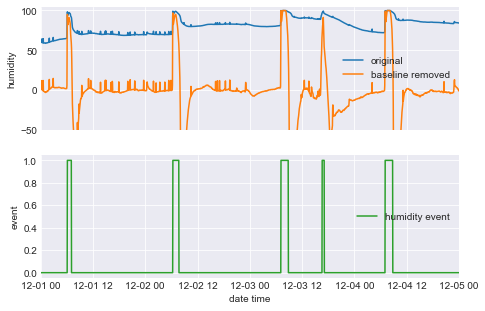

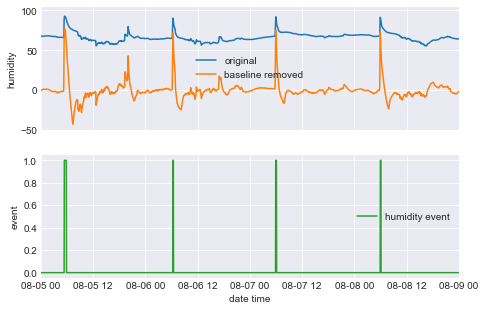

In [210]:

fig,ax = plot_humidity_data(df)
ax[1].set_xlim([datetime.date(2017,12,1), datetime.date(2017,12,5)])

fig,ax = plot_humidity_data(df)
ax[1].set_xlim([datetime.date(2017,8,5), datetime.date(2017,8,9)])


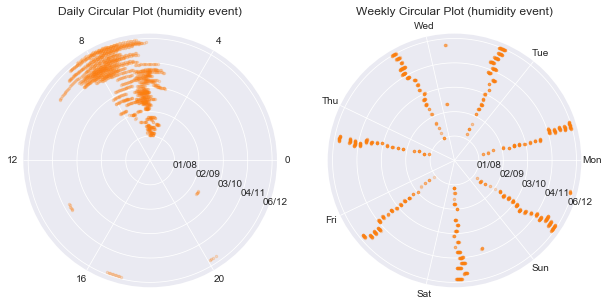

In [211]:
fig,ax = plot_humidity_circular(df, event)


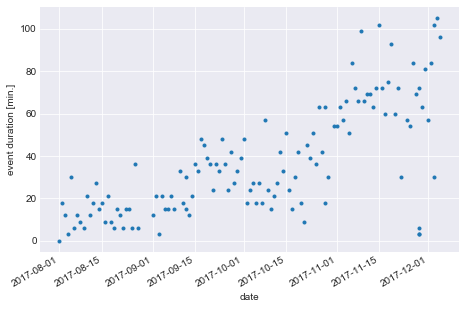

In [214]:
fig,ax = plot_humidity_event_duration(df, duration)